# Arrows Integration Demo

This notebook will demonstrate how to use the arrows.app web app to design a data model, then use Runway to generate and ingest your data. This notebook uses Runway v0.12.0

## Arrows

First we design a model in arrows. In order to track property types and unique properties we need to format our arrows model a bit differently than normal.

We need to format properties in the following way: `<propertyName>: <csv_mapping> | <Python type> | <unique> or <nodekey> | <ignore>`. If a property is not unique or a node key, then there is no need to provide the third parameter.

Identifying a property as unique will create a uniqueness constraint and index. 

Identifying a property as nodekey will create a node key constraint and index on that node including all marked properties.

Sometimes there are CSV columns that refer to the same property. In this case a `Person` node has the property name. This name property is mapped to the CSV columns `name` and `knows` where `knows` identifies another `Person` that has a `KNOWS` relationship with the `Person` identified with name. We can notate this with a comma-separated list where the first column mapping is the source and the second column mapping is the target node. So in this example this will look like the following:

```cypher
(Person {name: csv.name})-[:KNOWS]->(:Person {name: csv.knows})
```

If a property should not be considered for data ingestion, such as a property that is created during the post ingestion phase, then it can be identified by providing `ignore` as the final parameter. 

We can identify the source CSV of a node or relationship by including a property entry like so `csv: <csv name>`. If all data is from a single CSV, then we can exclude this entry and identify the single CSV name when generating the ingestion code later on.


This will ensure that when we import into Runway, we can maintain all important attributes of our data model.

![Pet Graph](../../images/runway-pet-data-model-0.2.0.png "Pet Graph")

Then we can export it as a JSON file to use with Neo4j Runway.

## Runway

In [1]:
from neo4j_runway import DataModel

We can easily ingest the arrows JSON file into a Runway compatible data model.

In [2]:
model = DataModel.from_arrows(file_path="../../data_models/pet-model-0.2.0.json")

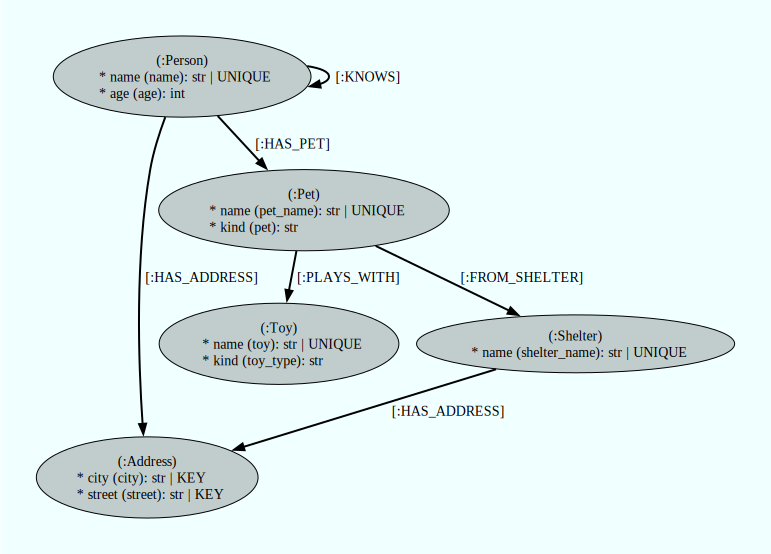

In [3]:
model.visualize()

And then we can generate some ingestion code to get our data into Neo4j.

In [4]:
from neo4j_runway.code_generation import LoadCSVCodeGenerator

We won't include a csv name here, since we identify the appropriate csv names in the data model. We also identify the file_directory argument as "./". This is because we are storing the data in the import directory of our local Neo4j instance and the LOAD CSV command will look relative to this directory.

In [5]:
gen = LoadCSVCodeGenerator(data_model=model, file_directory="./", file_output_directory="./outputs/", method="browser")

When generating the LOAD CSV Cypher code, we indicate the method as "browser" since we'll be copy and pasting the code into a Neo4j browser cell. If you plan on using the code with one of the Neo4j drivers or an api, then you can indicate the method as "api" or leave the field blank.

The below method will generate a Python string containing the LOAD CSV script.

In [6]:
load_csv_cypher = gen.generate_load_csv_cypher_string()

In [7]:
print(load_csv_cypher)

CREATE CONSTRAINT person_name IF NOT EXISTS FOR (n:Person) REQUIRE n.name IS UNIQUE;
CREATE CONSTRAINT address_city_street IF NOT EXISTS FOR (n:Address) REQUIRE (n.city, n.street) IS NODE KEY;
CREATE CONSTRAINT pet_name IF NOT EXISTS FOR (n:Pet) REQUIRE n.name IS UNIQUE;
CREATE CONSTRAINT toy_name IF NOT EXISTS FOR (n:Toy) REQUIRE n.name IS UNIQUE;
CREATE CONSTRAINT shelter_name IF NOT EXISTS FOR (n:Shelter) REQUIRE n.name IS UNIQUE;
:auto LOAD CSV WITH HEADERS FROM 'file:///./pets-2.csv' as row
CALL {
    WITH row
    MERGE (n:Person {name: row.name})
    SET n.age = toIntegerOrNull(row.age)
} IN TRANSACTIONS OF 100 ROWS;
:auto LOAD CSV WITH HEADERS FROM 'file:///./pets-2.csv' as row
CALL {
    WITH row
    MERGE (n:Address {city: row.city, street: row.street})
} IN TRANSACTIONS OF 100 ROWS;
:auto LOAD CSV WITH HEADERS FROM 'file:///./pets-2.csv' as row
CALL {
    WITH row
    MERGE (n:Pet {name: row.pet_name})
    SET n.kind = row.pet
} IN TRANSACTIONS OF 100 ROWS;
:auto LOAD CSV WIT

This method will output a LOAD CSV cypher file.

In [8]:
gen.generate_load_csv_cypher_file(file_name="pets_load_csv.cypher")
gen.generate_cypher_file()
gen.generate_constraints_file()

file dir:  ./outputs/pets_load_csv.cypher


After running this code in the Neo4j browser cell, we get this graph.

![Pet Graph](../../images/runway-pet-graph-browser.png "Pet Graph")